In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Load Recipe Data
file_paths = ["/content/drive/MyDrive/recipes_raw_nosource_ar.json",
              "/content/drive/MyDrive/recipes_raw_nosource_epi.json",
              "/content/drive/MyDrive/recipes_raw_nosource_fn.json"]

recipes = []
for file in file_paths:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        for key, recipe in data.items():
            recipes.append(recipe)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Convert to DataFrame
df = pd.DataFrame(recipes)

# Keep only necessary columns
df = df[["title", "ingredients", "instructions"]].dropna()

df.head()

,title,ingredients,instructions
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ..."
1,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....
3,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....
4,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...


In [6]:
# Clean "ADVERTISEMENT" text from ingredients
def clean_ingredients(ingredient_list):
    if isinstance(ingredient_list, list):
        return " ".join(re.sub(r"ADVERTISEMENT", "", ing).strip() for ing in ingredient_list)
    return ""

df["ingredients"] = df["ingredients"].apply(clean_ingredients)

In [7]:
# Clean instructions text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df["instructions"] = df["instructions"].apply(clean_text)

In [8]:
# Extract Cook Time from Instructions
def extract_cook_time(instructions):
    if not isinstance(instructions, str):
        return np.nan
    match = re.search(r"(\d+)\s*(?:minutes|min|m|hour|hr|h)", instructions)
    if match:
        value = int(match.group(1))
        if "hour" in match.group(0) or "hr" in match.group(0) or "h" in match.group(0):
            return value * 60  # Convert hours to minutes
        return value  # Already in minutes
    return np.nan

df["cookTime"] = df["instructions"].apply(extract_cook_time)

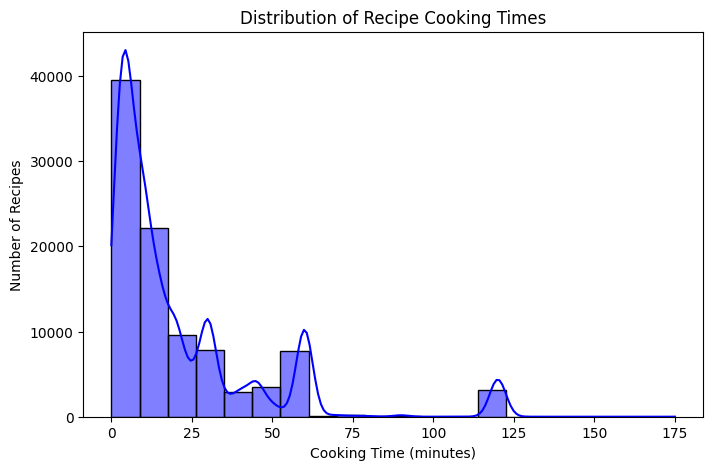

In [9]:
# Filter out extreme values (e.g., NaN or very high outliers)
df_filtered = df[df["cookTime"] < 180]  # Exclude recipes over 3 hours

# Create a histogram
plt.figure(figsize=(8, 5))
sns.histplot(df_filtered["cookTime"], bins=20, kde=True, color="blue")
plt.xlabel("Cooking Time (minutes)")
plt.ylabel("Number of Recipes")
plt.title("Distribution of Recipe Cooking Times")

# Show plot
plt.show()

In [10]:
# Combine ingredients and instructions for better recommendation
df["text_features"] = df["ingredients"] + " " + df["instructions"]

In [11]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["text_features"])

In [12]:
# Define taste categories
taste_profiles = {
    "spicy": {
        "chili", "cayenne", "jalapeño", "hot sauce", "sriracha", "black pepper",
        "red pepper flakes", "gochujang", "chipotle", "habanero", "wasabi",
        "smoked paprika", "thai chili", "ghost pepper", "carolina reaper", "scotch bonnet",
        "bird’s eye chili", "dried chili", "chili flakes", "chile", "chiles"
    },
    "sweet": {
        "sugar", "honey", "maple syrup", "caramel", "fruit", "chocolate", "vanilla",
        "cinnamon", "molasses", "dates", "agave", "condensed milk", "coconut milk"
    },
    "savory": {
        "garlic", "onion", "soy sauce", "mushroom", "cheese", "broth", "worcestershire sauce",
        "miso", "beef", "pork", "chicken", "fermented foods", "egg yolk", "tomato paste",
        "anchovies", "bouillon", "bacon"
    },
    "sour": {
        "lemon", "lime", "vinegar", "yogurt", "tamarind", "pickles", "cranberries",
        "pomegranate", "buttermilk", "sour cream"
    },
    "bitter": {
        "coffee", "cocoa", "dark chocolate", "kale", "radish", "turmeric",
        "grapefruit", "green tea", "dandelion greens", "bitter melon", "chicory",
        "whole cloves", "black tea"
    },
    "salty": {
        "salt", "anchovies", "soy sauce", "miso", "olives", "bacon", "salted butter",
        "seaweed", "prosciutto", "parmesan", "feta cheese"
    },
    "herbal": {
        "basil", "oregano", "rosemary", "thyme", "sage", "parsley", "cilantro", "dill",
        "chives", "bay leaf", "lemongrass"
    },
    "smoky": {
        "smoked paprika", "chipotle", "bacon", "BBQ sauce", "lapsang souchong", "liquid smoke",
        "grilled meat"
    },
    "fruity": {
        "berries", "apples", "peaches", "oranges", "pineapples", "mango", "grapes",
        "plums", "cherries", "figs", "passionfruit"
    },
    "nutty": {
        "almonds", "peanuts", "cashews", "walnuts", "hazelnuts", "sesame", "tahini",
        "pecans", "sunflower seeds"
    }
}

# Function to classify taste based on ingredients
def classify_taste(ingredients):
    detected_tastes = set()
    for ingredient in ingredients.split():
        for taste, keywords in taste_profiles.items():
            if any(kw in ingredient.lower() for kw in keywords):
                detected_tastes.add(taste)
    return list(detected_tastes) if detected_tastes else ["unknown"]

df["taste"] = df["ingredients"].apply(classify_taste)

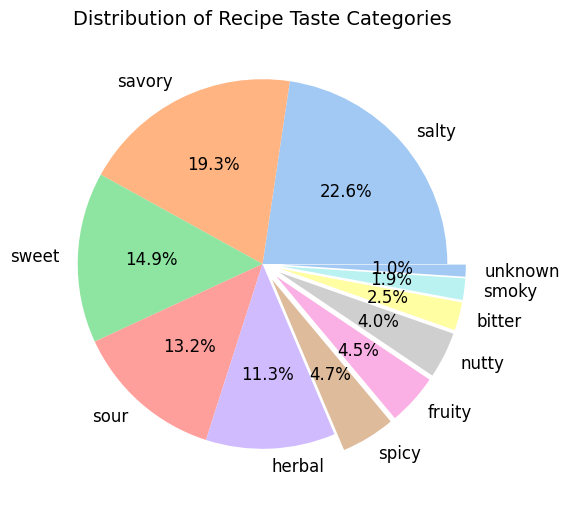

In [13]:
# Count occurrences of each taste category
taste_counts = df["taste"].explode().value_counts()

# Define a color palette with better contrast
colors = sns.color_palette("pastel", len(taste_counts))

# Define explode values (highlight "unknown" & small categories)
explode_values = [0.1 if taste in ["unknown", "smoky", "bitter", "nutty", "fruity", "spicy"] else 0 for taste in taste_counts.index]

# Create a clearer pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    taste_counts, labels=taste_counts.index, autopct="%1.1f%%",
    colors=colors, explode=explode_values, textprops={"fontsize": 12}
)
plt.title("Distribution of Recipe Taste Categories", fontsize=14)

# Show plot
plt.show()

In [14]:
def recommend_recipes(user_ingredients, max_time=None, preferred_taste=None, top_n=5):
    user_query = " ".join([clean_text(ing) for ing in user_ingredients])
    user_vector = vectorizer.transform([user_query])

    similarities = cosine_similarity(user_vector, tfidf_matrix).flatten()
    df["similarity"] = similarities

    filtered_df = df
    if max_time:
        filtered_df = df[df["cookTime"] <= max_time]

    if preferred_taste:
        filtered_df = filtered_df[filtered_df["taste"].apply(lambda x: preferred_taste in x)]

    recommendations = filtered_df.sort_values(by="similarity", ascending=False).head(top_n)

    # Add the cosine similarity to the recommendations DataFrame
    recommendations = recommendations[["title", "ingredients","cookTime", "taste", "similarity"]]

    return recommendations

In [15]:
recommendations = recommend_recipes(["chicken", "garlic", "lemon"], max_time=30, preferred_taste="savory")
display(recommendations)

,title,ingredients,cookTime,taste,similarity
47332,Lemon Chicken,1 tablespoon butter 1 tablespoon olive oil 2 b...,2.0,"[savory, herbal, sour]",0.574074
31045,Home-Style Chicken Piccata,1/2 cup all-purpose flour 2 teaspoons garlic p...,3.0,"[savory, sour]",0.533424
81843,Quickest Roasted Chicken Dinner,2 chicken breasts with skin and on the bone 4 ...,25.0,"[savory, herbal, sour, salty]",0.524106
18024,Rich Herb and Lemon Chicken,"4 skinless, boneless chicken breast halves sal...",2.0,"[savory, herbal, sour, salty]",0.518332
45169,Rosemary-Roasted Chicken and Garlic,2 chicken breast halves with skin and bones 2 ...,15.0,"[savory, herbal, salty]",0.513002


In [16]:
from tabulate import tabulate

def display_recommendations(recommendations):
    if recommendations.empty:
        print("No matching recipes found.")
        return

    # Select relevant columns and format into a clean table
    recommendations = recommendations[["title", "ingredients", "cookTime", "taste", "similarity"]]

    # Convert DataFrame to tabulated format
    print(tabulate(recommendations, headers="keys", tablefmt="fancy_grid"))

# Run the recommendation system
recommendations = recommend_recipes(["chicken", "garlic", "lemon"], max_time=30, preferred_taste="savory")

# Display formatted table
display_recommendations(recommendations)

╒═══════╤═════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤════════════╤═══════════════════════════════════════╤══════════════╕
│       │ title                               │ ingredients                                                                                                                                                                                                                                                                                                                                                                  │   cookTime │ taste                                 │   similarity │
╞═══════╪═════════════════════════

In [17]:
import random

# Expanded ingredient choices with more variety
ingredient_choices = [
    # Proteins
    "chicken", "beef", "pork", "fish", "tofu", "shrimp", "lamb", "turkey", "duck", "salmon",
    "tuna", "crab", "lobster", "bacon", "sausage", "ham", "tilapia", "sardine", "mackerel",
    "quail", "venison", "goat", "scallops", "octopus", "squid", "snail", "rabbit",

    # Vegetables
    "tomato", "onion", "garlic", "carrot", "spinach", "broccoli", "bell pepper", "mushroom",
    "potato", "cucumber", "zucchini", "cauliflower", "cabbage", "peas", "eggplant", "asparagus",
    "okra", "radish", "kale", "bok choy", "leek", "turnip", "parsnip", "beet", "chard",
    "watercress", "artichoke", "brussels sprouts", "celery", "fennel", "jicama", "daikon",
    "bamboo shoots", "chayote", "seaweed", "lotus root",

    # Dairy & Eggs
    "cheese", "milk", "butter", "yogurt", "cream", "egg", "parmesan", "mozzarella", "cheddar",
    "ghee", "buttermilk", "ricotta", "feta", "brie", "camembert", "gorgonzola", "goat cheese",
    "paneer", "halloumi", "blue cheese", "cream cheese", "cottage cheese", "sour cream",
    "evaporated milk", "condensed milk", "whipped cream", "quail eggs",

    # Grains & Legumes
    "rice", "pasta", "quinoa", "lentils", "beans", "oats", "bread", "corn", "barley", "millet",
    "bulgur", "couscous", "chickpeas", "black beans", "kidney beans", "navy beans", "soybeans",
    "wild rice", "buckwheat", "teff", "farro", "spelt", "rye", "polenta", "tortilla", "soba noodles",
    "udon noodles", "vermicelli", "amaranth", "mung beans",

    # Spices & Condiments
    "salt", "pepper", "soy sauce", "vinegar", "mustard", "curry powder", "cinnamon", "paprika",
    "oregano", "basil", "rosemary", "thyme", "turmeric", "nutmeg", "coriander", "clove", "saffron",
    "mace", "star anise", "fenugreek", "wasabi", "cumin", "cardamom", "sumac", "tamarind",
    "chipotle", "garam masala", "five-spice powder", "miso paste", "harissa", "fish sauce",
    "hoisin sauce", "teriyaki sauce", "worcestershire sauce", "ponzu sauce", "sriracha",
    "hot sauce", "smoked paprika", "coconut aminos", "sesame oil", "truffle oil",

    # Fruits
    "apple", "banana", "orange", "grapes", "peach", "pear", "mango", "cherry", "strawberry",
    "blueberry", "pineapple", "kiwi", "papaya", "watermelon", "cantaloupe", "honeydew",
    "pomegranate", "fig", "date", "plum", "apricot", "passionfruit", "lychee", "dragon fruit",
    "guava", "coconut", "cranberry", "blackberry", "raspberry", "persimmon",

    # Nuts & Seeds
    "almond", "walnut", "cashew", "peanut", "sesame", "flaxseed", "sunflower seed", "chia seed",
    "pistachio", "macadamia", "hazelnut", "pecan", "pine nut", "brazil nut", "hemp seed",
    "pumpkin seed", "caraway seed", "nigella seed", "mustard seed",

    # Others
    "maple syrup", "honey", "chocolate", "cocoa", "coffee", "green tea", "black tea",
    "molasses", "coconut milk", "almond milk", "oat milk", "soy milk", "margarine",
    "agave syrup", "date syrup", "coconut sugar", "brown sugar", "dark chocolate",
    "white chocolate", "vanilla extract", "almond extract", "rose water", "orange zest",
    "lemon zest", "lime zest"
]

# Taste preference choices (including None for no taste preference)
taste_choices = list(taste_profiles.keys()) + [None]

# Adjusted cook time distribution
def generate_cook_time():
    if random.random() < 0.8:  # 80% chance to select from 10-90 min
        return random.randint(10, 90)
    else:  # 20% chance to include long cook times (90-180 min)
        return random.randint(91, 180)

# Generate at least 200 unique test queries (allow buffer)
test_queries = set()
while len(test_queries) < 210:
    ingredients = tuple(random.sample(ingredient_choices, 3))  # Ensure 3 distinct ingredients
    max_time = generate_cook_time()  # Use weighted function for cook time
    preferred_taste = random.choice(taste_choices)  # Randomly assign a taste preference or None

    test_queries.add((ingredients, max_time, preferred_taste))

test_queries = list(test_queries)

In [18]:
# Evaluation Function
def evaluate_system(test_queries, top_n=5):
    correct_matches = 0
    total_queries = len(test_queries)
    total_precision = 0
    reciprocal_ranks = []

    for query in test_queries:
        user_ingredients, max_time, preferred_taste = query
        recommendations = recommend_recipes(user_ingredients, max_time, preferred_taste, top_n)

        if recommendations.empty:
            continue  # Skip if no recommendations

        # Check if at least one ingredient is in the recipe
        valid_recommendations = []
        for _, row in recommendations.iterrows():
            has_valid_time = row["cookTime"] <= max_time if not pd.isna(row["cookTime"]) else False
            has_valid_ingredient = any(ing in row["ingredients"] for ing in user_ingredients)
            has_valid_taste = preferred_taste in row["taste"] if preferred_taste and isinstance(row["taste"], list) else True

            if has_valid_time and has_valid_ingredient and has_valid_taste:
                valid_recommendations.append(row)

        # Convert to DataFrame to avoid "truth value of a Series is ambiguous" error
        valid_recommendations = pd.DataFrame(valid_recommendations)

        # Calculate Precision @ k
        precision_at_k = len(valid_recommendations) / top_n
        total_precision += precision_at_k

        # Check if there is at least one correct match
        if not valid_recommendations.empty:
            correct_matches += 1

            # Mean Reciprocal Rank (MRR) - Fix by checking titles instead of entire rows
            rank = next((i + 1 for i, row in enumerate(recommendations.iterrows())
                         if row[1]["title"] in valid_recommendations["title"].values), top_n)
            reciprocal_ranks.append(1 / rank)

    # Compute evaluation metrics
    accuracy = correct_matches / total_queries
    avg_precision = total_precision / total_queries
    mrr = sum(reciprocal_ranks) / len(reciprocal_ranks) if reciprocal_ranks else 0

    # Print final evaluation results
    print(f"Evaluation Results:")
    print(f"- Accuracy (Simple Relevance Fraction): {accuracy:.2f}")
    print(f"- Precision @ {top_n}: {avg_precision:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {mrr:.2f}")

# Run the evaluation
evaluate_system(test_queries)

Evaluation Results:
- Accuracy (Simple Relevance Fraction): 1.00
- Precision @ 5: 0.90
- Mean Reciprocal Rank (MRR): 0.95


<ipython-input-21-21423fa2148f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="Blues", width=0.6)


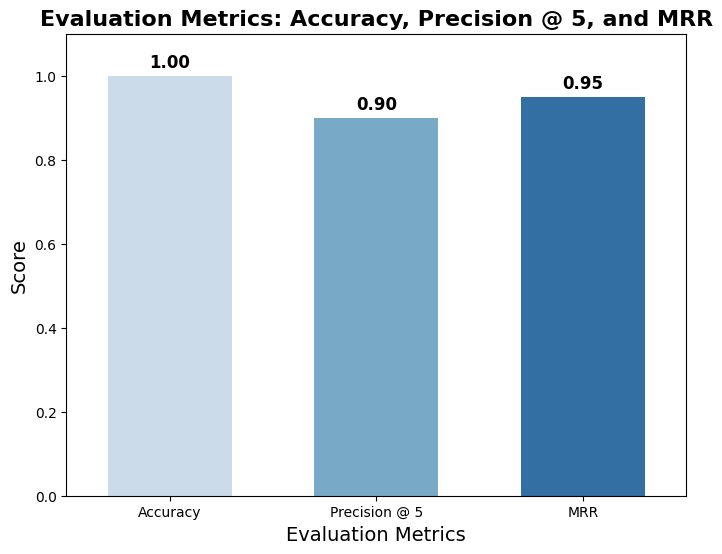

In [21]:
# Evaluation metrics
metrics = ["Accuracy", "Precision @ 5", "MRR"]
values = [1.00, 0.90, 0.95]

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=values, palette="Blues", width=0.6)

# Add text labels (numerical values) on each bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12, fontweight='bold')

# Set axis labels and title
plt.ylim(0, 1.1)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Evaluation Metrics", fontsize=14)
plt.title("Evaluation Metrics: Accuracy, Precision @ 5, and MRR", fontsize=16, fontweight="bold")

plt.show()